# Clasificación simple de género - Técnicas avanzadas de regresión

Base de datos de Kaggle: https://www.kaggle.com/datasets/muhammadtalharasool/simple-gender-classification

En este notebook se muestra un análisis exploratorio de datos junto a varias técnicas de regresión para  la predicción del género a partir de las características descritas a continuación.  

Acerca del conjunto de datos

Las 10 columnas de esta plantilla son:

- ID: identificador único para cada individuo en el conjunto de datos <br>
- Género: hombre o mujer<br>
- Edad: edad en años<br>
- Altura (cm): altura en centímetros<br>
- Peso (kg): peso en kilogramos<br>
- Ocupación: profesión o puesto de trabajo<br>
- Nivel educativo: nivel educativo más alto alcanzado<br>
- Estado civil: soltero, casado, divorciado, viudo, etc.<br>
- Ingresos (USD): ingresos anuales en dólares estadounidenses<br>
- Color favorito: color favorito de la persona (esta columna es solo por diversión y no tiene un significado real)<br>

Este conjunto de datos se puede utilizar para diversas tareas de clasificación y análisis de datos, como predecir el género o el nivel de ingresos de una persona en función de su ocupación, nivel de educación y otros factores demográficos.

In [1]:
# Se importan las librerías necesarias para el análisis

import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression,PoissonRegressor
from sklearn.linear_model import Lasso,GammaRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor


In [2]:
# Se carga el dataframe y se visualizan sus dimensiones 

df = pd.read_csv('gender.csv')
print('Dimensiones del dataframe: ',df.shape)
df.head()

Dimensiones del dataframe:  (131, 10)


,Gender,Age,Height (cm),Weight (kg),Occupation,Education Level,Marital Status,Income (USD),Favorite Color,Unnamed: 9
0,male,32,175,70,Software Engineer,Master's Degree,Married,75000,Blue,NaN
1,male,25,182,85,Sales Representative,Bachelor's Degree,Single,45000,Green,NaN
2,female,41,160,62,Doctor,Doctorate Degree,Married,120000,Purple,NaN
3,male,38,178,79,Lawyer,Bachelor's Degree,Single,90000,Red,NaN
4,female,29,165,58,Graphic Designer,Associate's Degree,Single,35000,Yellow,NaN


In [3]:
# Descripción estadística de las variables numéricas del dataframe 

df.describe()

,Age,Height (cm),Weight (kg),Income (USD),Unnamed: 9
count,131.000000,131.000000,131.000000,131.000000,0.0
mean,34.564885,173.198473,71.458015,93206.106870,NaN
std,5.984723,8.045467,12.648052,74045.382919,NaN
min,24.000000,160.000000,50.000000,30000.000000,NaN
25%,29.000000,166.000000,60.000000,55000.000000,NaN
50%,34.000000,175.000000,75.000000,75000.000000,NaN
75%,39.000000,180.500000,83.000000,100000.000000,NaN
max,52.000000,190.000000,94.000000,500000.000000,NaN


In [4]:
# Información general del dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0    Gender           131 non-null    object 
 1    Age              131 non-null    int64  
 2    Height (cm)      131 non-null    int64  
 3    Weight (kg)      131 non-null    int64  
 4    Occupation       131 non-null    object 
 5    Education Level  131 non-null    object 
 6    Marital Status   131 non-null    object 
 7    Income (USD)     131 non-null    int64  
 8    Favorite Color   131 non-null    object 
 9   Unnamed: 9        0 non-null      float64
dtypes: float64(1), int64(4), object(5)
memory usage: 10.4+ KB


De la información del dataframe se puede ver que la columna Unnamed: 9 no contienen valores. Las demás columnas no presentan valores nulos. <br> De la exploración de los datos se encontró que tanto las etiquetas de las columnas como los valores de las columnas contenían espacios vacíos lo que dificulta su procesamiento, por lo que es necesario eliminar estos espacios.

In [5]:
# función para eliminar espacios en blanco contenidos en las columnas

def eliminar_espacios(dataframe):
    for columna in dataframe.columns:
        if dataframe[columna].dtype == 'object': 
            dataframe[columna] = dataframe[columna].str.strip()
            
    return dataframe

In [6]:
# Se eliminan los espacios en blanco en las etiquetas de las columnas

df = df.rename(columns=lambda x: x.strip())

# Se aliminan los espacios en blanco contenidos en las columnas

df = eliminar_espacios(df)

Se eliminan las columnas de 'Unnamed: 9' y 'Favorite Color' por no aportar información relevante al analisis.

In [7]:
# Se eliminan las columnas de 'Unnamed: 9' y 'Favorite Color'

cols = ['Unnamed: 9', 'Favorite Color']
df = df.drop(cols, axis=1)

## Análisis Exploratorio de Datos 

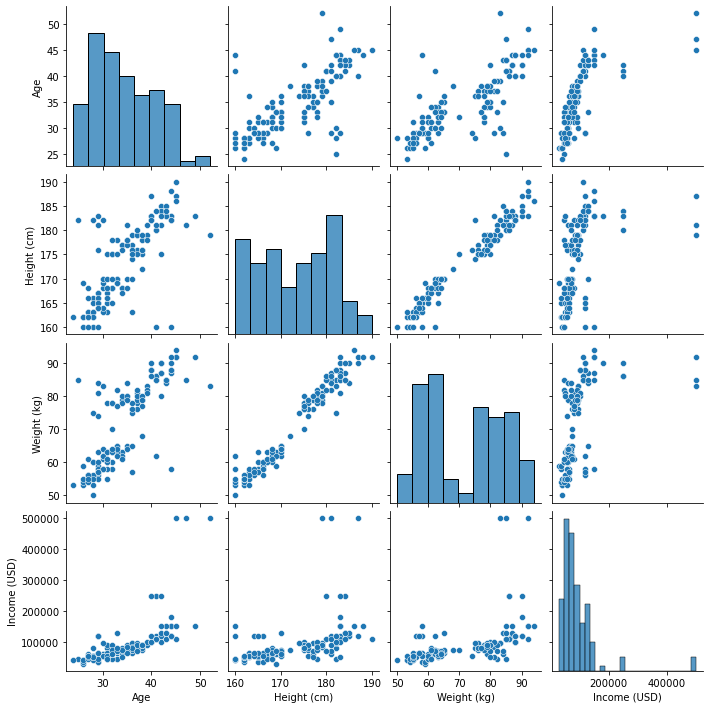

In [8]:
# Se grafican las relaciones cruzadas de todas las variables numéricas del dataframe

sns.pairplot(df)

De la anterior grafica anterior se puede concluir que: 
- La gráfica de ingresos se encuentra sesgada por lo que podría ser necesario normalizarla
- Las columnas de altura y peso estas fuertemente correlacionadas y oresentan una brecha posiblemente debida al genero 
- Las distribuciones de peso y altura pueden contener una brecha que representa la diferencia de genero


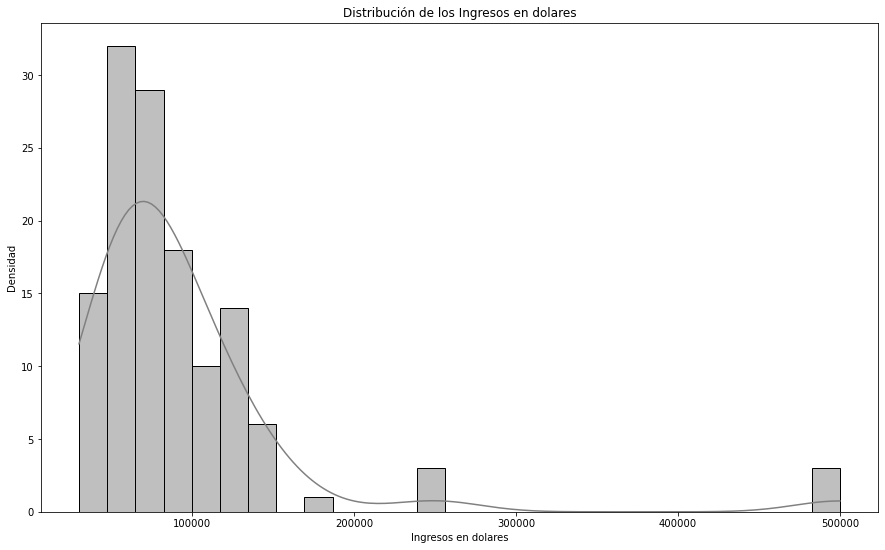

In [9]:
# Grafica de las distribución de ingresos en dólares 

f, ax = plt.subplots(figsize=(15,9))
sns.histplot(df['Income (USD)'], color="gray", kde=True)
ax.set(xlabel="Ingresos en dolares")
ax.set(ylabel="Densidad")
ax.set(title="Distribución de los Ingresos en dolares")
plt.show()

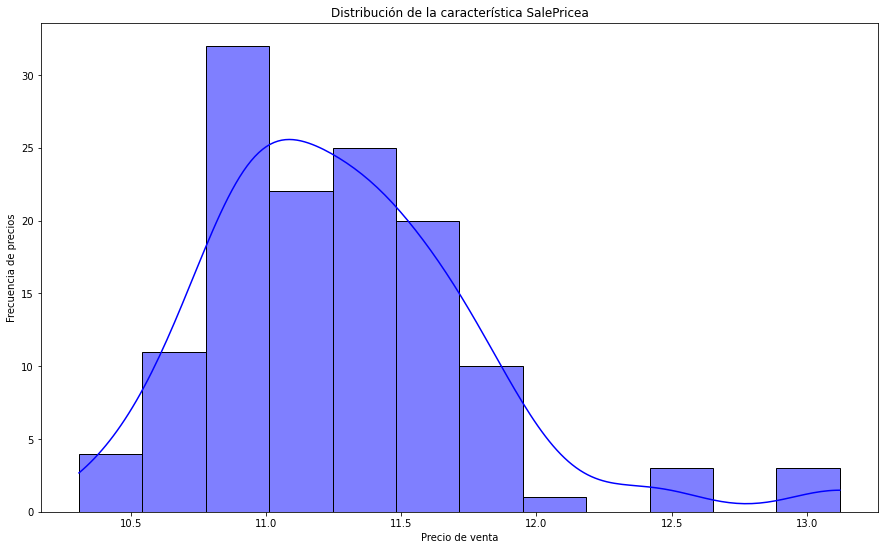

In [10]:
# Se normaliza la distribución 

df['Income (USD)'] = np.log1p(df['Income (USD)'])

f, ax = plt.subplots(figsize=(15,9))
sns.histplot(df['Income (USD)'], color="blue", kde=True)
ax.set(ylabel="Frecuencia de precios")
ax.set(xlabel="Precio de venta")
ax.set(title="Distribución de la característica SalePricea")
plt.show()

A continuación se desarrolla el análisis enfocado en el genero

In [11]:
# se crean subcategorías por genero

genero_femenino = df[df['Gender'] == 'female']
genero_masculino = df[df['Gender'] == 'male']

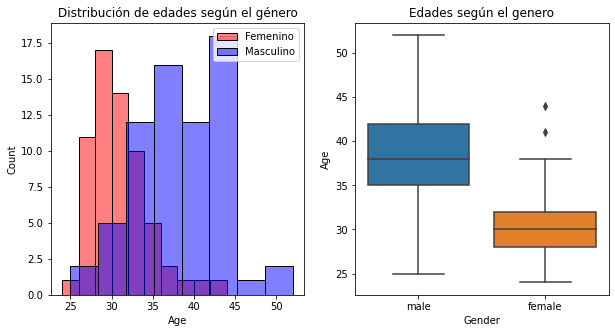

In [12]:
# se grafica la distribución de edades según el genero

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

sns.histplot(data=genero_femenino, x="Age", color="red", alpha=0.5, label="Femenino", ax=ax1)
sns.histplot(data=genero_masculino, x="Age", color="blue", alpha=0.5, label="Masculino", ax=ax1)
ax1.legend()
ax1.set_title('Distribución de edades según el género')

sns.boxplot(data=df, x="Gender", y="Age", ax=ax2)
ax2.set_title('Edades según el genero')

plt.show()

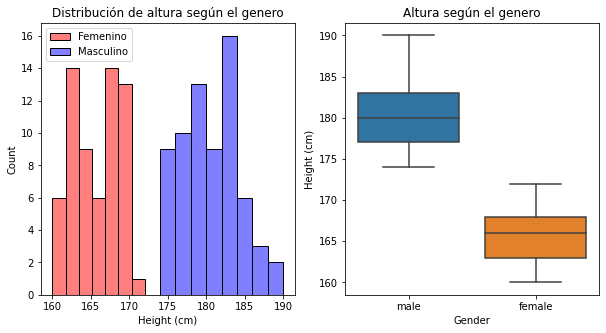

In [13]:
# Se grafica la distribución de altura según el genero

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

sns.histplot(data=genero_femenino, x="Height (cm)", color="red", alpha=0.5, label="Femenino", ax=ax1)
sns.histplot(data=genero_masculino, x="Height (cm)", color="blue", alpha=0.5, label="Masculino", ax=ax1)
ax1.legend()
ax1.set_title('Distribución de altura según el genero')

sns.boxplot(data=df, x="Gender", y="Height (cm)",ax=ax2)
ax2.set_title("Altura según el genero")
plt.show()

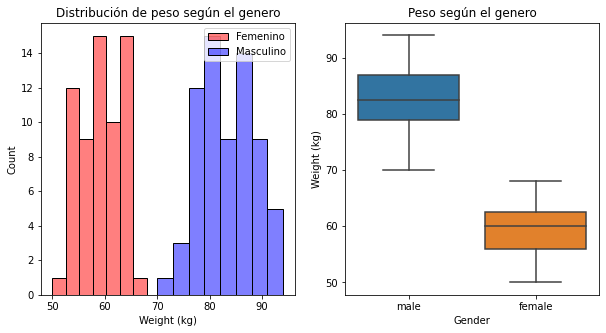

In [14]:
# Se grafica la distribución de peso según el genero

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

sns.histplot(data=genero_femenino, x="Weight (kg)", color="red", alpha=0.5, label="Femenino", ax=ax1)
sns.histplot(data=genero_masculino, x="Weight (kg)", color="blue", alpha=0.5, label="Masculino", ax=ax1)
ax1.legend()
ax1.set_title('Distribución de peso según el genero')

sns.boxplot(data=df, x="Gender", y="Weight (kg)",ax=ax2)
ax2.set_title("Peso según el genero")
plt.show()

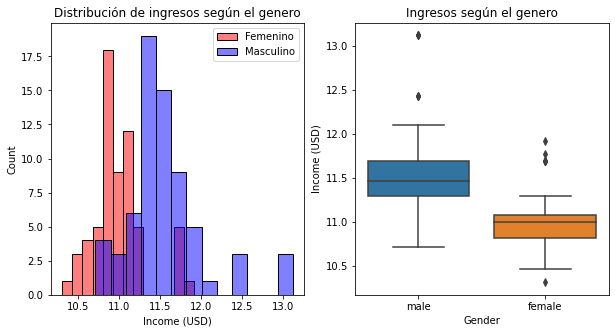

In [15]:
# Se grafica la distribución de ingresos según el genero

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

sns.histplot(data=genero_femenino, x="Income (USD)", color="red", alpha=0.5, label="Femenino", ax=ax1)
sns.histplot(data=genero_masculino, x="Income (USD)", color="blue", alpha=0.5, label="Masculino", ax=ax1)
ax1.legend()
ax1.set_title('Distribución de ingresos según el genero')

sns.boxplot(data=df, x="Gender", y="Income (USD)",ax=ax2)
ax2.set_title("Ingresos según el genero")
plt.show()

Al observar las gráficas anteriores, se evidencia que las distribuciones de las características muestran diferencias significativas o brechas que pueden ser utilizadas para predecir el género del sujeto a partir de dichas características.

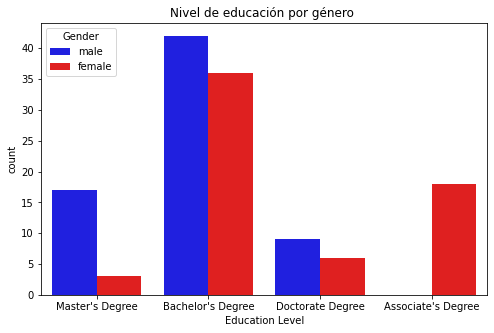

In [16]:
# Grafica de nivel de educación por género 

fig, ax = plt.subplots(figsize=(8,5))

sns.countplot(data=df, x="Education Level", hue="Gender", palette=["blue", "red"], ax=ax)
ax.set_title("Nivel de educación por género ")

plt.show()

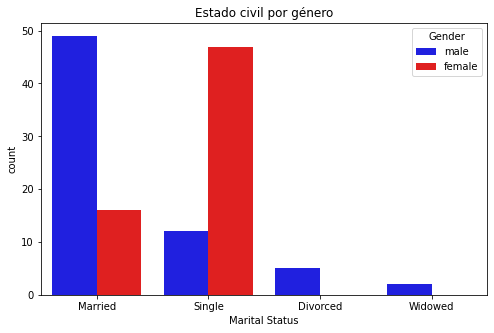

In [17]:
# Grafica de estado civil por género 

fig, ax = plt.subplots(figsize=(8,5))

sns.countplot(data=df, x="Marital Status", hue="Gender", palette=["blue", "red"], ax=ax)
ax.set_title("Estado civil por género")

plt.show()

Con el fin de ampliar el análisis transformamos las variables categóricas en variables  numéricas para integrarlas 

In [18]:
# Se transforman la variables categóricas en numericas

# masculino = 1, femenino = 0
le = LabelEncoder()
for i in df.columns:
    if df[i].dtype == 'object':
       df[i] = le.fit_transform(df[i])

<AxesSubplot:>

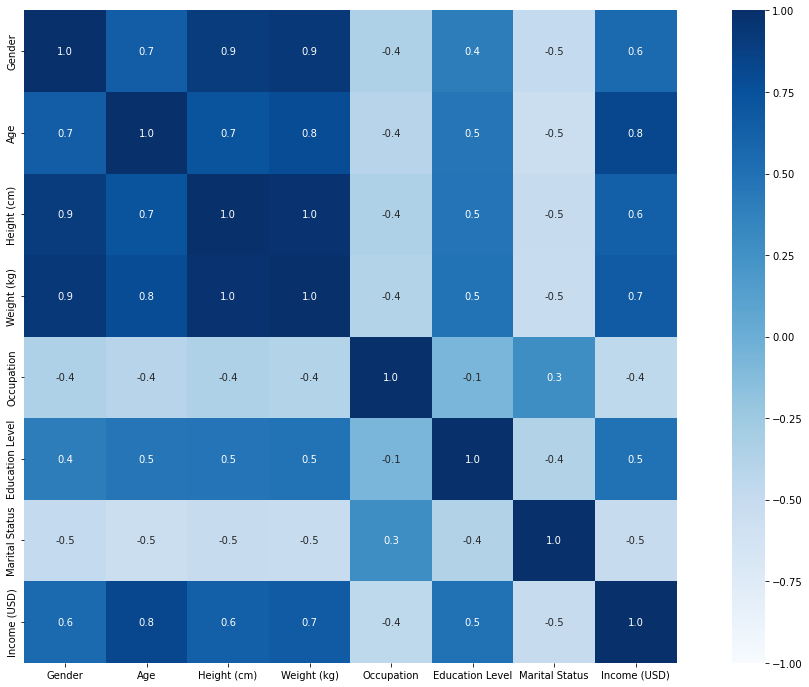

In [19]:
# Analisis correlacional
plt.subplots(figsize=(20,12))
sns.heatmap(df.corr(), cmap="Blues", annot=True, vmin=-1, vmax=1, fmt='.1f', square = True)

La matriz de correlación muestra de las dos características mayormente relacionadas con el genero son altura y peso. 

## Preprocesamiento y aplicación de modelos de regresión 

In [20]:
# Separación de datos de entrenamiento y prueba 

X = df.drop('Gender', axis=1)
y = df['Gender']

In [21]:
# Estandarización de los datos

sc = StandardScaler()
X = sc.fit_transform(X)

In [22]:
# función para las métricas de evaluación de los modelos 

def evaluation(y,predictions):
    mae = mean_absolute_error(y,predictions)  # error absoluto medio
    mse = mean_squared_error(y,predictions)  # error cuadrático medio 
    rmse = np.sqrt(mean_squared_error(y,predictions)) # raiz del error cuadrático medio
    return mae,mse,rmse

In [23]:
# Regresor de vector de soporte SVR

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=799,test_size=0.2)
svr = SVR()
svr.fit(X_train,y_train)
ypred = svr.predict(X_test)
acc_svr = r2_score(y_test,ypred)
mae,mse,rmse = evaluation(y_test,ypred)
print("r_squared :",acc_svr.round(6))
print("")
print("Raiz del error cuadrático medio rmse :",rmse.round(6))
print("")
print("Error cuadrático medio mse :",mse.round(6))
print("")
print("Error absoluto medio mae :",mae.round(6))

r_squared : 0.923723

Raiz del error cuadrático medio rmse : 0.137996

Error cuadrático medio mse : 0.019043

Error absoluto medio mae : 0.112676


In [24]:
# Regresión lineal  

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=804,test_size=0.2)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
ypred1 = lin_reg.predict(X_test)
acc_rl = r2_score(y_test,ypred1)
mae,mse,rmse = evaluation(y_test,ypred1)
print("r_squared :",acc_rl.round(6))
print("")
print("Raiz del error cuadrático medio rmse :",rmse.round(6))
print("")
print("Error cuadrático medio mse :",mse.round(6))
print("")
print("Error absoluto medio mae :",mae.round(6))

r_squared : 0.902818

Raiz del error cuadrático medio rmse : 0.155763

Error cuadrático medio mse : 0.024262

Error absoluto medio mae : 0.122456


In [25]:
# Regresión Lasso   

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=804,test_size=0.2)
lasso = Lasso()
lasso.fit(X_train,y_train)
ypred2 = lasso.predict(X_test)
acc_lasso = r2_score(y_test,ypred2)
mae,mse,rmse = evaluation(y_test,ypred2)
print("r_squared :",acc_lasso.round(6))
print("")
print("Raiz del error cuadrático medio rmse :",rmse.round(6))
print("")
print("Error cuadrático medio mse :",mse.round(6))
print("")
print("Error absoluto medio mae :",mae.round(6))

r_squared : -2e-06

Raiz del error cuadrático medio rmse : 0.499657

Error cuadrático medio mse : 0.249658

Error absoluto medio mae : 0.499288


In [26]:
# Regresor de Poission

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=804,test_size=0.2)
poisson = PoissonRegressor()
poisson.fit(X_train,y_train)
ypred3 = poisson.predict(X_test)
acc_poission = r2_score(y_test,ypred3)
mae,mse,rmse = evaluation(y_test,ypred3)
print("r_squared :",acc_poission.round(6))
print("")
print("Raiz del error cuadrático medio rmse :",rmse.round(6))
print("")
print("Error cuadrático medio mse :",mse.round(6))
print("")
print("Error absoluto medio mae :",mae.round(6))

r_squared : 0.564559

Raiz del error cuadrático medio rmse : 0.329714

Error cuadrático medio mse : 0.108711

Error absoluto medio mae : 0.309458


In [27]:
# Regresor de Aumento de gradiente

np.random.seed(1182)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1182,test_size=0.2) # Did it for 2000 epochs
gbr = GradientBoostingRegressor(alpha=0.9, criterion='mse', max_depth=100,max_leaf_nodes=7, min_samples_leaf=4,n_estimators=250)
gbr.fit(X_train,y_train)
ypred4 = gbr.predict(X_test)
acc_gra = r2_score(y_test,ypred4)
mae,mse,rmse = evaluation(y_test,ypred4)
print("r_squared :",acc_gra.round(6))
print("")
print("Raiz del error cuadrático medio rmse :",rmse.round(6))
print("")
print("Error cuadrático medio mse :",mse.round(6))
print("")
print("Error absoluto medio mae :",mae.round(6))

r_squared : 0.944009

Raiz del error cuadrático medio rmse : 0.114267

Error cuadrático medio mse : 0.013057

Error absoluto medio mae : 0.021991


In [28]:
# Regresor KNeighbours

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=804,test_size=0.2)
knr = KNeighborsRegressor()
knr.fit(X_train,y_train)
ypred5 = knr.predict(X_test)
acc_kn = r2_score(y_test,ypred5)
mae,mse,rmse = evaluation(y_test,ypred5)
print("r_squared :",acc_kn.round(6))
print("")
print("Raiz del error cuadrático medio rmse :",rmse.round(6))
print("")
print("Error cuadrático medio mse :",mse.round(6))
print("")
print("Error absoluto medio mae :",mae.round(6))

r_squared : 0.994066

Raiz del error cuadrático medio rmse : 0.03849

Error cuadrático medio mse : 0.001481

Error absoluto medio mae : 0.007407


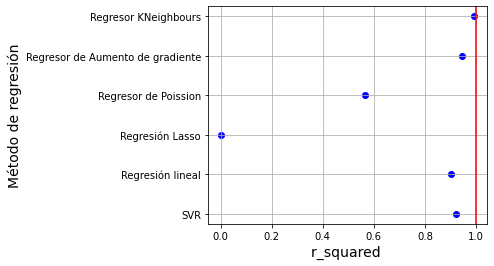

In [29]:
# Se grafican lo métodos de regresión con sus respectivos r2_score o r_squared

plt.subplots(figsize=(5,4))
y = ['SVR','Regresión lineal', 'Regresión Lasso','Regresor de Poission', 'Regresor de Aumento de gradiente', 'Regresor KNeighbours']
x = [acc_svr, acc_rl, acc_lasso, acc_poission, acc_gra, acc_kn]
plt.scatter(x, y,color='blue', marker='o')
plt.xlabel('r_squared ', fontsize=14) 
plt.ylabel('Método de regresión', fontsize=14) 

plt.grid(True)
plt.axvline(x=1, color='r', linestyle='-')
plt.show()

Como se puede ver en la grafica el modelo con mejor rendimiento para este conjunto de datos resulta ser el Regresor KNeighbours con un r_squared : 0.994066